# Credit Card Fraud – Anomaly Detection & Explainability


## Dependencies

In [ ]:
%pip -q install numpy pandas joblib cloudpickle matplotlib seaborn shap lime scikit-learn

print("All dependencies for Isolation Forest installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
All dependencies for Isolation Forest installed


## Imports

In [ ]:
import os
import json
import joblib
import cloudpickle
import numpy as np
import pandas as pd
import re
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import shap

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="X has feature names, but IsolationForest was fitted without feature names")

## Parameters

In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

RANDOM_STATE = 42
RESULTS_DIR = Path('/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams')
PREPROCESSOR_TYPE = 'tree'

DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/processed_data')
PREPROCESSOR_FILE = f"preprocessor_{PREPROCESSOR_TYPE}.pkl"

CONTAMINATION_RATE = 'auto'

N_FRAUD_SAMPLES = 50
N_NORMAL_SAMPLES = 150

BACKGROUND_SIZE = 500

Mounted at /content/drive


## Loading Data

In [ ]:
from scipy.sparse import load_npz

def load_features(data_dir, preprocessor_type, data_name):
    """Loads pre-computed features, handling both sparse and dense formats."""
    base_path = data_dir / f"{data_name}_{preprocessor_type}"
    path_npz = base_path.with_suffix('.npz')
    path_npy = base_path.with_suffix('.npy')

    if path_npz.exists():
        return load_npz(path_npz)
    elif path_npy.exists():
        return np.load(path_npy)
    else:
        raise FileNotFoundError(f"Data not found for {base_path}")

print(f"--- Loading data for '{PREPROCESSOR_TYPE}' preprocessor ---")

X_train = load_features(DATA_DIR, PREPROCESSOR_TYPE, 'X_train_transformed')
X_test = load_features(DATA_DIR, PREPROCESSOR_TYPE, 'X_test_transformed')
y_train = np.load(DATA_DIR / "y_train.npy")
y_test = np.load(DATA_DIR / "y_test.npy")

if CONTAMINATION_RATE == 'auto':
    contamination = y_train.mean()
    print(f"Using Contamination Rate calculated from y_train: {contamination:.4f}")
else:
    contamination = CONTAMINATION_RATE

print("Data loaded successfully.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

--- Loading data for 'tree' preprocessor ---
Using Contamination Rate calculated from y_train: 0.0030
Data loaded successfully.
X_train shape: (978768, 41)
X_test shape: (244692, 41)


## Isolation Forest

### Hyperparameter Tuning with GridSearchCV

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

RANDOM_STATE = 42
SUBSET_MAX_N = 200_000
FINAL_N_ESTIMATORS = 300
FINAL_MAX_SAMPLES = "auto"
N_JOBS_SEARCH = -1
N_JOBS_IFOREST = 1

def iforest_auc(estimator, X, y_true):
    scores = estimator.decision_function(X)
    return roc_auc_score(y_true, -scores)

X, y = X_train, y_train

if X.dtype != np.float32:
    X = X.astype(np.float32, copy=False)

n_pos = int(np.sum(y == 1))
n_splits = max(2, min(5, n_pos))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

n_samples = X.shape[0]
if n_samples > SUBSET_MAX_N:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=SUBSET_MAX_N, random_state=RANDOM_STATE)
    (sub_idx, _), = sss.split(X, y)
    X_tune = X[sub_idx]
    y_tune = y[sub_idx]
else:
    X_tune = X
    y_tune = y

param_grid = {
    "n_estimators": [100, 200],
    "max_samples": [256, 512, 1024, 4096, 16384],
    "max_features": [0.75, 1.0],
    "bootstrap": [False],
}

base_iforest = IsolationForest(
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS_IFOREST,
)

hs = HalvingGridSearchCV(
    estimator=base_iforest,
    param_grid=param_grid,
    factor=3,
    resource='n_samples',
    min_resources='exhaust',
    scoring=iforest_auc,
    cv=cv,
    n_jobs=N_JOBS_SEARCH,
    refit=True,
    verbose=1,
    error_score='raise'
)

print("Starting HalvingGridSearchCV for IsolationForest on tuning subset...")
hs.fit(X_tune, y_tune)
TUNED_PARAMS = hs.best_params_
BEST_CV_SCORE = hs.best_score_
print("Best params (tuning subset):", TUNED_PARAMS)
print("Best CV ROC-AUC (anomaly-positive):", BEST_CV_SCORE)

final_params = dict(TUNED_PARAMS)
final_params["n_estimators"] = FINAL_N_ESTIMATORS
final_params["max_samples"] = FINAL_MAX_SAMPLES

final_iforest = IsolationForest(
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS_IFOREST,
    **final_params
)

print("Refitting best model on FULL training data...")
final_iforest.fit(X, y)

BEST_MODEL = final_iforest
BEST_PARAMS_TUNING = TUNED_PARAMS
BEST_CV_ROC_AUC_TUNING = BEST_CV_SCORE

print("Final refit complete.")
print("Final params used on full data:", final_params)

Starting HalvingGridSearchCV for IsolationForest on tuning subset...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 22222
max_resources_: 200000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 22222
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 1
n_candidates: 7
n_resources: 66666
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 2
n_candidates: 3
n_resources: 199998
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params (tuning subset): {'bootstrap': False, 'max_features': 1.0, 'max_samples': 1024, 'n_estimators': 100}
Best CV ROC-AUC (anomaly-positive): 0.8118149565447403
Refitting best model on FULL training data...
Final refit complete.
Final params used on full data: {'bootstrap': False, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


### Train and Evaluate Model

Training Isolation Forest model...
Model training complete.

--- Evaluating model on Training Set ---
Precision: 0.0482
Recall:    0.0482
F1-Score:  0.0482
ROC AUC:   0.8007
PR AUC:    0.0178


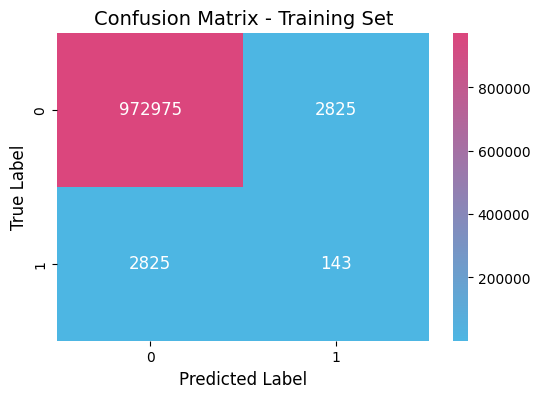


--- Evaluating model on Test Set ---
Precision: 0.0323
Recall:    0.0323
F1-Score:  0.0323
ROC AUC:   0.7888
PR AUC:    0.0164


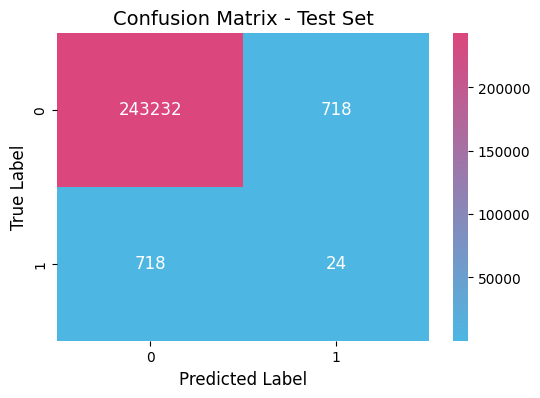


Trained Isolation Forest saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/isolation_forest_model.joblib


In [ ]:
from scipy.sparse import issparse

def to_dense(data):
    """Converts sparse matrix to dense if necessary."""
    return data.toarray() if issparse(data) else data

def train_isolation_forest(X, contamination_rate, random_state=RANDOM_STATE):
    """Trains an Isolation Forest model."""
    print("Training Isolation Forest model...")
    # Use tuned hyperparameters if available; fall back to defaults
    params = dict(TUNED_PARAMS) if 'TUNED_PARAMS' in globals() else {}
    params.update({
        "contamination": contamination_rate,
        "random_state": random_state,
        "n_jobs": -1
    })
    model = IsolationForest(**params)
    model.fit(to_dense(X))
    print("Model training complete.")
    return model

def evaluate_model(model, X, y, data_label="Test Set"):
    """Evaluates the trained Isolation Forest model."""
    print(f"\n--- Evaluating model on {data_label} ---")

    anomaly_scores = -model.decision_function(to_dense(X))

    threshold = np.percentile(anomaly_scores, 100 * (1 - model.contamination))
    y_pred = (anomaly_scores >= threshold).astype(int)

    metrics = {
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y, anomaly_scores),
        "pr_auc": average_precision_score(y, anomaly_scores),
    }

    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
    print(f"PR AUC:    {metrics['pr_auc']:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    custom_cmap = LinearSegmentedColormap.from_list('custom', ['#4db6e3', '#db467d'])
    sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt="g", annot_kws={"size": 12})
    plt.title(f"Confusion Matrix - {data_label}", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()

    return y_pred, anomaly_scores, metrics, cm

if_model = train_isolation_forest(X_train, contamination)

train_preds, train_scores, train_metrics, train_cm = evaluate_model(if_model, X_train, y_train, "Training Set")
test_preds, test_scores, test_metrics, test_cm = evaluate_model(if_model, X_test, y_test, "Test Set")

output_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model")
output_dir.mkdir(parents=True, exist_ok=True)
model_path = output_dir / "isolation_forest_model.joblib"
joblib.dump(if_model, model_path)
print(f"\nTrained Isolation Forest saved to: {model_path}")

### Build Background and Evaluation Subsets

In [ ]:
rng = np.random.default_rng(RANDOM_STATE)

X_train_dense = to_dense(X_train)
X_test_dense  = to_dense(X_test)

idx_train_normal = np.where(y_train == 0)[0]
idx_train_fraud  = np.where(y_train == 1)[0]

bg_size = min(BACKGROUND_SIZE, len(idx_train_normal))
bg_indices = rng.choice(idx_train_normal, size=bg_size, replace=False)
X_background = X_train_dense[bg_indices]

n_fraud   = min(N_FRAUD_SAMPLES, len(idx_train_fraud))
n_normal  = min(N_NORMAL_SAMPLES, len(idx_train_normal))

panel_fraud_idx  = rng.choice(idx_train_fraud,  size=n_fraud,  replace=False)
panel_normal_idx = rng.choice(idx_train_normal, size=n_normal, replace=False)

X_panel = np.vstack([X_train_dense[panel_fraud_idx], X_train_dense[panel_normal_idx]])
y_panel = np.concatenate([y_train[panel_fraud_idx], y_train[panel_normal_idx]])

# Compute scores for panel
panel_scores = -if_model.decision_function(X_panel)

# Save subsets
np.save(output_dir / "X_background.npy", X_background)
np.save(output_dir / "X_panel.npy", X_panel)
np.save(output_dir / "y_panel.npy", y_panel)
np.save(output_dir / "panel_scores.npy", panel_scores)

try:
    with open(DATA_DIR / "feature_names.json", "r") as f:
        feature_names = json.load(f)
    if isinstance(feature_names, dict):
        # If stored as dict
        feature_names = feature_names.get("feature_names", None)
except Exception:
    feature_names = None

if feature_names is None:
    feature_names = [f"f{i}" for i in range(X_panel.shape[1])]

with open(output_dir / "feature_names.json", "w") as f:
    json.dump({"feature_names": feature_names}, f, indent=2)

print("Background and evaluation subsets prepared and saved.")
print(f"X_background: {X_background.shape}, X_panel: {X_panel.shape}, y_panel: {y_panel.shape}")

Background and evaluation subsets prepared and saved.
X_background: (500, 41), X_panel: (200, 41), y_panel: (200,)


## Explain with SHAP TreeExplainer

Building SHAP TreeExplainer...
Computing SHAP values for panel...


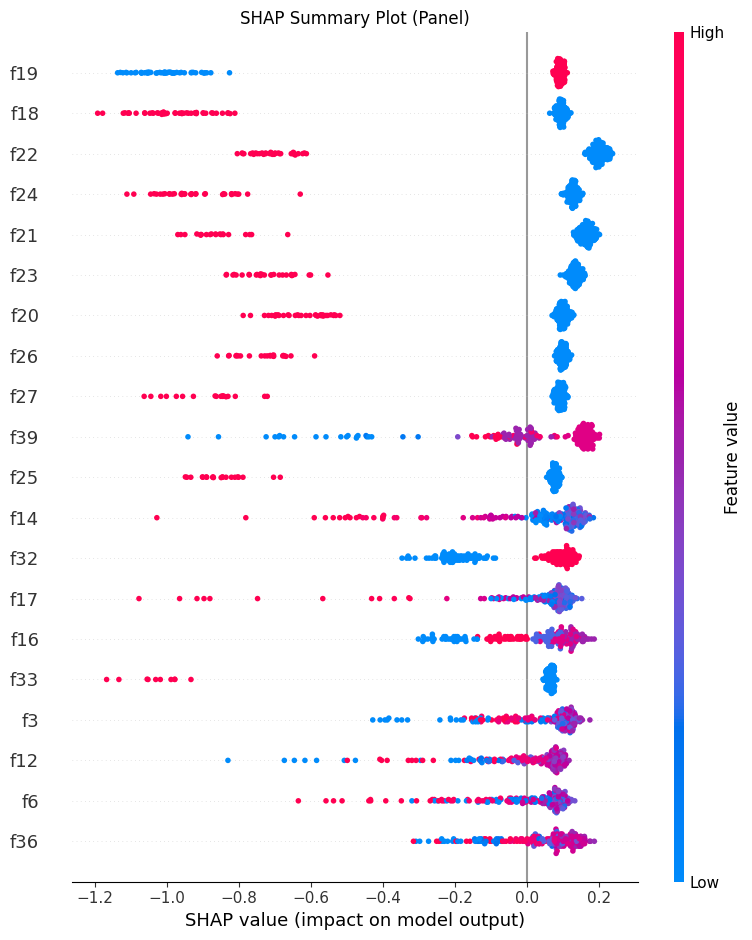

Saved SHAP summary plot to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/shap_summary_panel.png


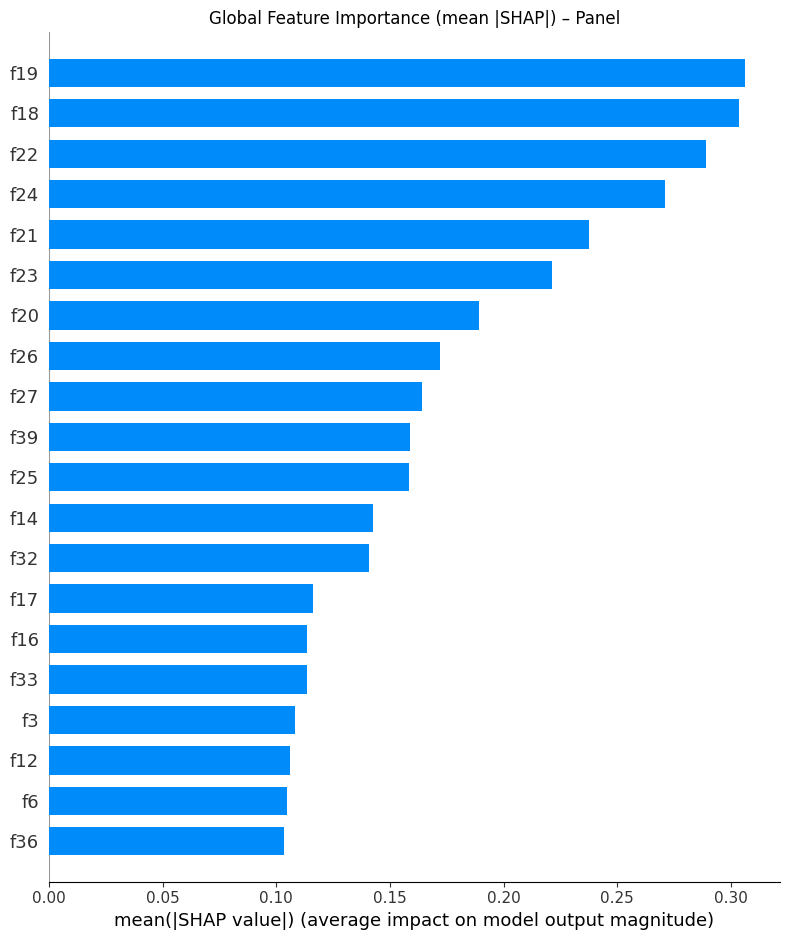

Saved SHAP bar summary to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/shap_summary_bar_panel.png


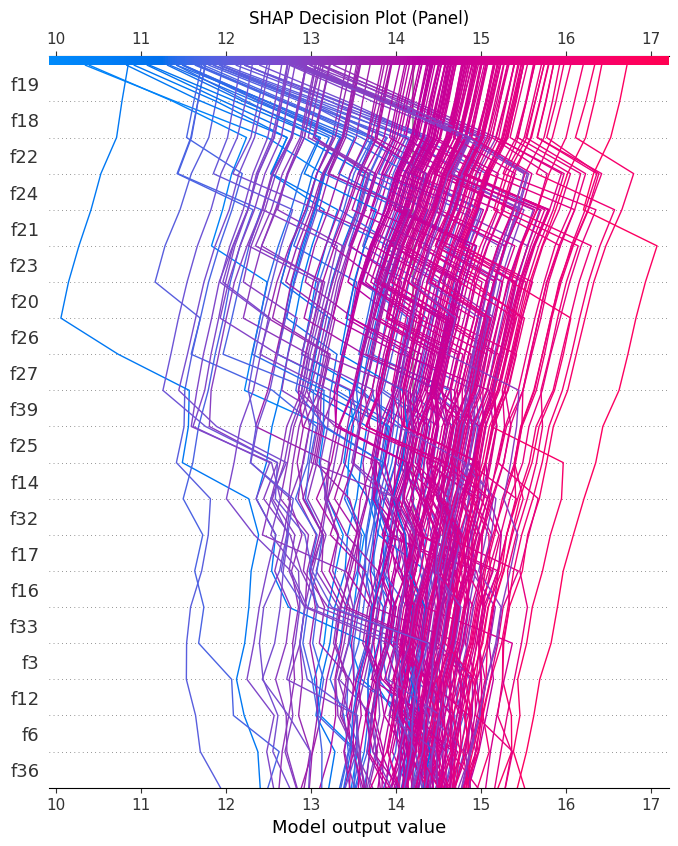

Saved SHAP decision plot to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/shap_decision_plot_panel.png


In [ ]:
bg_shap = X_background

print("Building SHAP TreeExplainer...")
explainer = shap.TreeExplainer(if_model, data=bg_shap, feature_perturbation="interventional")
print("Computing SHAP values for panel...")
shap_values = explainer.shap_values(X_panel)

np.save(output_dir / "shap_values_panel.npy", shap_values)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_panel, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot (Panel)")
plt.tight_layout()
summary_path = output_dir / "shap_summary_panel.png"
plt.savefig(summary_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved SHAP summary plot to: {summary_path}")

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_panel, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Global Feature Importance (mean |SHAP|) – Panel")
plt.tight_layout()
bar_path = output_dir / "shap_summary_bar_panel.png"
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved SHAP bar summary to: {bar_path}")

try:
    idx_example = 0
    shap_ex = shap_values[idx_example]
    base_value = explainer.expected_value
    shap.decision_plot(base_value, shap_values, feature_names=feature_names, show=False)
    decision_path = output_dir / "shap_decision_plot_panel.png"
    plt.title("SHAP Decision Plot (Panel)")
    plt.savefig(decision_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved SHAP decision plot to: {decision_path}")
except Exception as e:
    print("Skipped decision plot due to:", e)

## Explain with LIME TabularExplainer

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

X_train_for_lime = X_train_dense
class_names = ["normal", "fraud"]

def anomaly_proba(scores):
    s = np.asarray(scores)
    m = np.median(s)
    iqr = np.percentile(s, 75) - np.percentile(s, 25)
    iqr = iqr if iqr > 1e-8 else (np.std(s) + 1e-8)
    z = (s - m) / iqr
    p = 1 / (1 + np.exp(-z))
    return p

def lime_predict_proba(X):
    scores = -if_model.decision_function(to_dense(X))
    p_fraud = anomaly_proba(scores)
    p_normal = 1.0 - p_fraud
    return np.vstack([p_normal, p_fraud]).T

feature_names = feature_names
categorical_features = None

explainer_lime = LimeTabularExplainer(
    training_data=X_train_for_lime,
    feature_names=feature_names,
    class_names=class_names,
    categorical_features=categorical_features,
    discretize_continuous=True,
    random_state=RANDOM_STATE,
    verbose=False
)

examples_to_explain = min(5, X_panel.shape[0])
for i in range(examples_to_explain):
    x_i = X_panel[i]
    exp = explainer_lime.explain_instance(
        x_i,
        predict_fn=lime_predict_proba,
        num_features=10,
        labels=[0, 1]
    )
    html_path = output_dir / f"lime_explanation_panel_{i}.html"
    exp.save_to_file(str(html_path))
    print(f"Saved LIME explanation to: {html_path}")

print("LIME explanations generated.")

Saved LIME explanation to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/lime_explanation_panel_0.html
Saved LIME explanation to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/lime_explanation_panel_1.html
Saved LIME explanation to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/lime_explanation_panel_2.html
Saved LIME explanation to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/lime_explanation_panel_3.html
Saved LIME explanation to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/lime_explanation_panel_4.html
LIME explanations generated.


## LIME Stbaility Test

In [ ]:
import itertools
from statistics import mean, pstdev

def extract_topk_from_lime(exp, label=1, k=10):
    """
    Returns set of top-k feature indices by absolute weight for a given label.
    Uses exp.as_map() which provides (feature_index, weight).
    """
    amap = dict(exp.as_map())
    if label not in amap:
        return set()
    items = amap[label]
    top = sorted(items, key=lambda t: abs(t[1]), reverse=True)[:k]
    return set(idx for idx, w in top)

def lime_explain_with_seed(x, seed, num_features=10, num_samples=2000):
    """
    Re-instantiates the LIME explainer with a fresh random_state for each run,
    then explains a single instance x. Returns the Explanation object.
    """
    expl = LimeTabularExplainer(
        training_data=X_train_dense,
        feature_names=feature_names,
        class_names=["normal", "fraud"],
        categorical_features=None,
        discretize_continuous=True,
        random_state=seed,
        verbose=False
    )
    return expl.explain_instance(
        x,
        predict_fn=lime_predict_proba,
        num_features=num_features,
        labels=[0, 1],
        num_samples=num_samples
    )

def jaccard(a, b):
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union > 0 else 0.0

STAB_N_INSTANCES = min(10, X_panel.shape[0])
STAB_RUNS_PER_INSTANCE = 8
TOPK = 10

rng = np.random.default_rng(RANDOM_STATE)
sel_indices = rng.choice(np.arange(X_panel.shape[0]), size=STAB_N_INSTANCES, replace=False)

per_instance_stability = []
instance_details = []

for idx in sel_indices:
    x = X_panel[idx]
    sets = []
    seeds = list(range(1000, 1000 + STAB_RUNS_PER_INSTANCE))
    for sd in seeds:
        exp = lime_explain_with_seed(x, sd, num_features=TOPK, num_samples=2000)
        s = extract_topk_from_lime(exp, label=1, k=TOPK)
        sets.append(s)

    pairs = list(itertools.combinations(range(len(sets)), 2))
    overlaps = [jaccard(sets[i], sets[j]) for i, j in pairs]
    stab_score = float(mean(overlaps)) if overlaps else 0.0
    per_instance_stability.append(stab_score)

    instance_details.append({
        "panel_index": int(idx),
        "stability_topk_jaccard": stab_score,
        "runs": len(sets),
        "topk": TOPK
    })

lime_stability_summary = {
    "mean_stability_topk_jaccard": float(mean(per_instance_stability)) if per_instance_stability else 0.0,
    "std_stability_topk_jaccard": float(pstdev(per_instance_stability)) if len(per_instance_stability) > 1 else 0.0,
    "n_instances": int(STAB_N_INSTANCES),
    "runs_per_instance": int(STAB_RUNS_PER_INSTANCE),
    "topk": int(TOPK)
}

with open(output_dir / "lime_stability_summary.json", "w") as f:
    json.dump(lime_stability_summary, f, indent=2)

pd.DataFrame(instance_details).to_csv(output_dir / "lime_stability_per_instance.csv", index=False)

print("LIME stability test complete.")
print("Summary:", lime_stability_summary)
print("Saved per-instance details and summary to output_dir.")

LIME stability test complete.
Summary: {'mean_stability_topk_jaccard': 1.0, 'std_stability_topk_jaccard': 0.0, 'n_instances': 10, 'runs_per_instance': 8, 'topk': 10}
Saved per-instance details and summary to output_dir.


## Interpretability Metrics

Saved interpretability metrics and global importance tables.
{'topk_global_overlap_jaccard': 0.5384615384615384, 'topk_global_k': 10, 'lime_sparsity_mean_nonzero_features': 20.0, 'lime_sparsity_std_nonzero_features': 0.0, 'n_lime_global': 50}


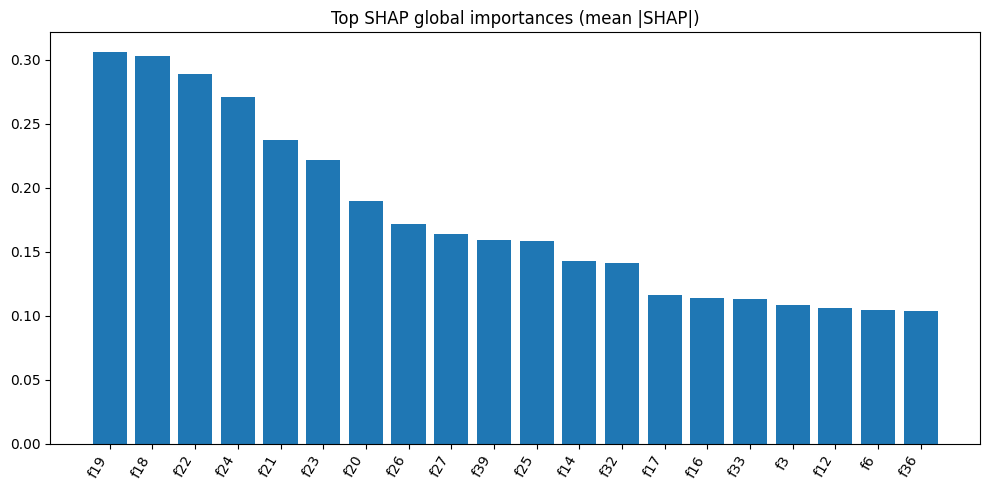

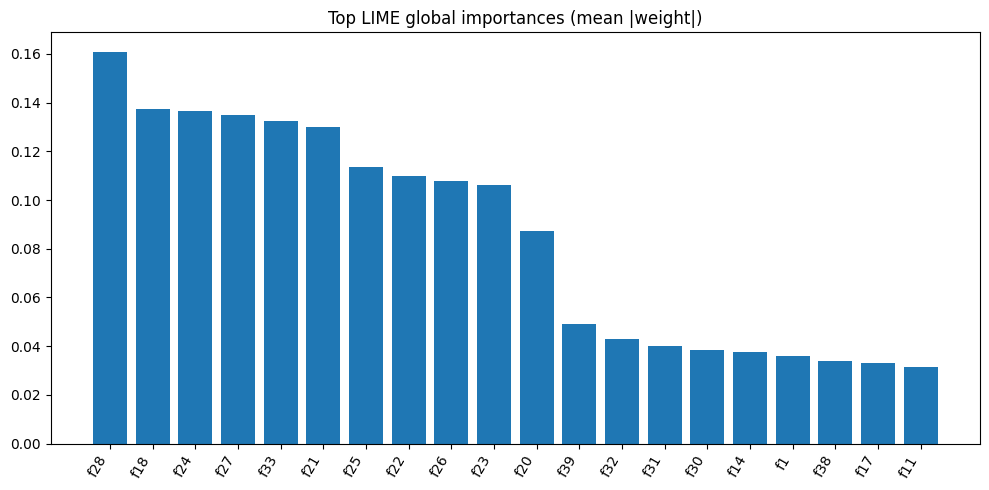

In [ ]:
from collections import defaultdict

def ensure_shap_matrix(values):
    """
    Handles SHAP return types:
    - If list (multi-output), take the first element (binary case often returns array)
    - If array-like, return as np.array
    """
    if isinstance(values, list):
        values = values[0]
    return np.asarray(values)

shap_vals = ensure_shap_matrix(shap_values)
assert shap_vals.shape[0] == X_panel.shape[0], "Mismatch: SHAP samples vs X_panel"
shap_global = np.mean(np.abs(shap_vals), axis=0)

df_shap_global = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": shap_global
}).sort_values("mean_abs_shap", ascending=False)
df_shap_global.to_csv(output_dir / "global_importance_shap.csv", index=False)

N_LIME_GLOBAL = min(50, X_panel.shape[0])
lime_weights_accum = defaultdict(list)

for i in range(N_LIME_GLOBAL):
    x_i = X_panel[i]
    exp = explainer_lime.explain_instance(
        x_i,
        predict_fn=lime_predict_proba,
        num_features=20,
        labels=[1]
    )
    amap = dict(exp.as_map())
    if 1 in amap:
        for feat_idx, weight in amap[1]:
            lime_weights_accum[feat_idx].append(abs(weight))

lime_global = np.zeros(X_panel.shape[1])
for feat_idx, weights in lime_weights_accum.items():
    lime_global[feat_idx] = float(np.mean(weights))

df_lime_global = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_lime_weight": lime_global
}).sort_values("mean_abs_lime_weight", ascending=False)
df_lime_global.to_csv(output_dir / "global_importance_lime.csv", index=False)

TOPK_IMP = 10
topk_shap_idx = set(np.argsort(-shap_global)[:TOPK_IMP])
topk_lime_idx = set(np.argsort(-lime_global)[:TOPK_IMP])
overlap_imp = len(topk_shap_idx & topk_lime_idx) / len(topk_shap_idx | topk_lime_idx) if (topk_shap_idx or topk_lime_idx) else 1.0

sparsity_counts = []
for i in range(N_LIME_GLOBAL):
    x_i = X_panel[i]
    exp = explainer_lime.explain_instance(
        x_i,
        predict_fn=lime_predict_proba,
        num_features=20,
        labels=[1]
    )
    amap = dict(exp.as_map())
    used = len(amap.get(1, []))
    sparsity_counts.append(used)

interpretability_metrics = {
    "topk_global_overlap_jaccard": float(overlap_imp),
    "topk_global_k": int(TOPK_IMP),
    "lime_sparsity_mean_nonzero_features": float(np.mean(sparsity_counts)) if sparsity_counts else 0.0,
    "lime_sparsity_std_nonzero_features": float(np.std(sparsity_counts)) if len(sparsity_counts) > 1 else 0.0,
    "n_lime_global": int(N_LIME_GLOBAL)
}

with open(output_dir / "interpretability_metrics.json", "w") as f:
    json.dump(interpretability_metrics, f, indent=2)

print("Saved interpretability metrics and global importance tables.")
print(interpretability_metrics)

TOPN_PLOT = 20

plt.figure(figsize=(10, 5))
order = np.argsort(-shap_global)[:TOPN_PLOT]
plt.bar(np.arange(TOPN_PLOT), shap_global[order])
plt.xticks(np.arange(TOPN_PLOT), [feature_names[i] for i in order], rotation=60, ha="right")
plt.title("Top SHAP global importances (mean |SHAP|)")
plt.tight_layout()
plt.savefig(output_dir / "plot_shap_global_topN.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 5))
order_l = np.argsort(-lime_global)[:TOPN_PLOT]
plt.bar(np.arange(TOPN_PLOT), lime_global[order_l])
plt.xticks(np.arange(TOPN_PLOT), [feature_names[i] for i in order_l], rotation=60, ha="right")
plt.title("Top LIME global importances (mean |weight|)")
plt.tight_layout()
plt.savefig(output_dir / "plot_lime_global_topN.png", dpi=200, bbox_inches="tight")
plt.show()

## Logging for Documentation

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer): return int(obj)
        if isinstance(obj, np.floating): return float(obj)
        if isinstance(obj, np.ndarray): return obj.tolist()
        return super(NpEncoder, self).default(obj)

def log_results(model_name, preprocessor_type, hyperparams, performance_metrics,
                interpretability_metrics, explainer_params, shap_values,
                feature_names, lime_explanations, eval_indices, base_dir):
    """
    base_dir: Path where the run folder is created (we use 'output_dir' from above).
    This function creates:
      base_dir / f"{model_name.lower().replace(' ', '')}_{preprocessor_type}_run"/
        - explanations/
            shap_aggregated_importances.csv
            lime_explanations.json
        - metrics/
            hyperparameters.json
            performance_metrics.json
            interpretability_metrics.json
            explainer_params.json
    """
    run_dir = base_dir / f"{model_name.lower().replace(' ', '')}_{preprocessor_type}_run"
    explain_dir = run_dir / "explanations"
    metrics_dir = run_dir / "metrics"
    run_dir.mkdir(parents=True, exist_ok=True)
    explain_dir.mkdir(exist_ok=True)
    metrics_dir.mkdir(exist_ok=True)

    with open(metrics_dir / "hyperparameters.json", "w") as f:
        json.dump(hyperparams, f, indent=4, cls=NpEncoder)

    with open(metrics_dir / "performance_metrics.json", "w") as f:
        json.dump(performance_metrics, f, indent=4, cls=NpEncoder)

    with open(metrics_dir / "interpretability_metrics.json", "w") as f:
        json.dump(interpretability_metrics, f, indent=4, cls=NpEncoder)

    with open(metrics_dir / "explainer_params.json", "w") as f:
        json.dump(explainer_params, f, indent=4, cls=NpEncoder)

    try:
        sv = shap_values[0] if isinstance(shap_values, list) else shap_values
        sv = np.asarray(sv)
        if sv.size > 0:
            mean_abs_shap = np.mean(np.abs(sv), axis=0)
            shap_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap_value": mean_abs_shap})
            shap_df.sort_values(by="mean_abs_shap_value", ascending=False, inplace=True)
            shap_df.to_csv(explain_dir / "shap_aggregated_importances.csv", index=False)
    except Exception as e:
        print("Skipping SHAP aggregation due to:", e)

    if lime_explanations:
        lime_out = []
        for i, exp in enumerate(lime_explanations):
            try:
                lime_out.append({
                    "original_panel_index": int(eval_indices[i]),
                    "explanation_label_1": exp.as_list(label=1)
                })
            except Exception:
                lime_out.append({
                    "original_panel_index": int(eval_indices[i]),
                    "explanation_default": exp.as_list()
                })
        with open(explain_dir / "lime_explanations.json", "w") as f:
            json.dump(lime_out, f, indent=4, cls=NpEncoder)

    print(f"All metrics and artifacts for '{model_name}' saved to: '{run_dir}'")

base_dir = output_dir

best_hparams = TUNED_PARAMS if 'TUNED_PARAMS' in globals() else {}

perf_metrics = {
    "train": train_metrics,
    "test": test_metrics
}

LIME_NUM_SAMPLES = 2000
explainer_parameters = {
    "shap_background_size": int(BACKGROUND_SIZE),
    "lime_kernel_width": None,
    "lime_num_samples": int(LIME_NUM_SAMPLES)
}

try:
    k = min(5, X_panel.shape[0])
    eval_indices = np.arange(k)
    lime_explanations_for_metrics = []
    for i in eval_indices:
        exp_i = explainer_lime.explain_instance(
            X_panel[i],
            predict_fn=lime_predict_proba,
            num_features=10,
            labels=[1],
            num_samples=LIME_NUM_SAMPLES
        )
        lime_explanations_for_metrics.append(exp_i)
except Exception as e:
    print("Warning: could not regenerate LIME explanations for logging:", e)
    lime_explanations_for_metrics = []
    eval_indices = np.array([], dtype=int)

log_results(
    model_name="TunedIsolationForest",
    preprocessor_type=PREPROCESSOR_TYPE,
    hyperparams=best_hparams,
    performance_metrics=perf_metrics,
    interpretability_metrics=interpretability_metrics,
    explainer_params=explainer_parameters,
    shap_values=shap_values,
    feature_names=feature_names,
    lime_explanations=lime_explanations_for_metrics,
    eval_indices=eval_indices,
    base_dir=base_dir
)

All metrics and artifacts for 'TunedIsolationForest' saved to: '/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/isolation_forest_model/tunedisolationforest_tree_run'
